## Part 1. Overview of CART (Classification And Regression Trees) for Classification

## Introduction

CART (Classification And Regression Trees) is a decision tree algorithm developed by Breiman et al. (1984) that builds binary trees for both classification and regression tasks. Unlike ID3, which we covered in class, CART uses different splitting criteria and creates strictly binary trees. In this project, we implement CART for classification problems.

## Representation

CART represents a classification model as a binary decision tree where:
- Each **internal node** represents a decision based on a single feature and threshold
- Each **edge** represents the outcome of the decision (left child for values ≤ threshold, right for values > threshold)  
- Each **leaf node** represents a class prediction

For a given input $\mathbf{x} = (x_1, x_2, ..., x_d)$, the prediction is made by:
1. Starting at the root node
2. Following decision rules down the tree: if $x_j \leq t$ go left, else go right
3. Returning the majority class at the reached leaf node

Mathematically, the tree partitions the feature space into disjoint regions $R_1, R_2, ..., R_M$ and predicts:

$$\hat{y}(\mathbf{x}) = \sum_{m=1}^{M} c_m \cdot \mathbb{1}(\mathbf{x} \in R_m)$$

where $c_m$ is the majority class in region $R_m$.

## Loss Function: Gini Impurity

CART uses the **Gini impurity** as the default criterion to measure the quality of a split. For a node containing samples from classes $1, 2, ..., K$, the Gini impurity is:

$$G = 1 - \sum_{k=1}^{K} p_k^2$$

where $p_k$ is the proportion of samples belonging to class $k$ in the node.

**Properties:**
- $G = 0$ when all samples belong to one class (pure node)
- $G$ is maximized when classes are equally distributed
- For binary classification: $G = 2p(1-p)$ where $p$ is the proportion of positive class

When evaluating a split at node $t$ using feature $j$ and threshold $\tau$, we compute the **Gini gain**:

$$\Delta G = G(t) - \frac{N_L}{N_t} G(t_L) - \frac{N_R}{N_t} G(t_R)$$

where:
- $G(t)$ is the Gini impurity of the parent node
- $G(t_L)$ and $G(t_R)$ are the Gini impurities of left and right children
- $N_t$, $N_L$, $N_R$ are the number of samples in parent, left child, and right child
- The split that maximizes $\Delta G$ is chosen

## Optimizer: Greedy Recursive Binary Splitting

CART builds trees using a **greedy, top-down, recursive partitioning** algorithm:

Algorithm: CART Tree Construction
Input: Dataset D = {(x_i, y_i)}_{i=1}^N, stopping criteria
Output: Binary decision tree T
function BUILD_TREE(D, depth):
if stopping_criterion(D, depth):
return LEAF_NODE(majority_class(D))

# Find best split
best_gain = 0
best_split = None

for each feature j in {1, ..., d}:
    # Sort unique values of feature j
    thresholds = unique_sorted_values(D[:, j])
    
    for each threshold τ in thresholds:
        # Split data
        D_left = {(x, y) ∈ D : x_j ≤ τ}
        D_right = {(x, y) ∈ D : x_j > τ}
        
        # Compute Gini gain
        gain = Gini(D) - |D_left|/|D| * Gini(D_left) - |D_right|/|D| * Gini(D_right)
        
        if gain > best_gain:
            best_gain = gain
            best_split = (j, τ)

if best_gain == 0:
    return LEAF_NODE(majority_class(D))

# Create node and recursively build subtrees
node = INTERNAL_NODE(best_split)
node.left = BUILD_TREE(D_left, depth + 1)
node.right = BUILD_TREE(D_right, depth + 1)

return node

**Stopping Criteria:**
- Maximum depth reached (`max_depth`)
- Minimum samples required to split (`min_samples_split`)
- Minimum samples at leaf node (`min_samples_leaf`)
- No improvement in Gini gain
- All samples belong to the same class (pure node)

**Complexity:**
- Training: $O(d \cdot N \log N \cdot \text{depth})$ where $d$ is number of features
- Prediction: $O(\text{depth})$ which is $O(\log N)$ for balanced trees

## Advantages

1. **Interpretability**: Tree structure is easy to visualize and understand
2. **Non-parametric**: No assumptions about data distribution
3. **Handles mixed data**: Works with both numerical and categorical features
4. **Feature interactions**: Automatically captures feature interactions
5. **Minimal preprocessing**: No need for feature scaling or normalization

## Disadvantages

1. **Overfitting**: Tendency to create overly complex trees that don't generalize
2. **Instability**: Small changes in data can result in very different trees
3. **Bias**: Biased toward features with more levels
4. **Local optimum**: Greedy algorithm doesn't guarantee global optimum
5. **High variance**: Individual trees have high variance (addressed by ensemble methods)

## References

Breiman, L., Friedman, J., Olshen, R., & Stone, C. (1984). *Classification and Regression Trees*. Wadsworth, Belmont, CA.

Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.11"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.11"):
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.10.5", 'numpy': "2.3.2",'sklearn': "1.7.1", 
                'pandas': "2.3.2", 'pytest': "8.4.1", 'torch':"2.7.1"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.11

[ OK ] matplotlib version 3.10.5 is installed.
[ OK ] numpy version 2.3.2 is installed.
[ OK ] sklearn version 1.7.1 is installed.
[ OK ] pandas version 2.3.2 is installed.
[ OK ] pytest version 8.4.1 is installed.
[ OK ] torch version 2.7.1 is installed.


## Part 2. Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class Node:
    """
    A node in the decision tree.
    
    Attributes:
        feature_idx: Index of feature to split on (None for leaf nodes)
        threshold: Threshold value for the split (None for leaf nodes)
        left: Left child node
        right: Right child node
        value: Class prediction for leaf nodes (None for internal nodes)
        gini: Gini impurity at this node
        n_samples: Number of samples at this node
    """
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None, gini=None, n_samples=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gini = gini
        self.n_samples = n_samples
        
    def is_leaf(self):
        """Check if node is a leaf node."""
        return self.value is not None


class DecisionTreeClassifier:
    """
    Decision Tree Classifier using CART algorithm with Gini impurity.
    
    This implementation follows the sklearn.tree.DecisionTreeClassifier API
    and uses binary splits with Gini impurity as the splitting criterion.
    """
    
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, random_state=None):
        """
        Initialize the Decision Tree Classifier.
        
        Parameters:
            criterion: str, default='gini'
                The function to measure split quality. Only 'gini' supported.
            max_depth: int or None, default=None
                Maximum depth of the tree. If None, nodes expand until pure or 
                min_samples_split is reached.
            min_samples_split: int, default=2
                Minimum number of samples required to split an internal node.
            min_samples_leaf: int, default=1
                Minimum number of samples required at a leaf node.
            random_state: int or None, default=None
                Random seed for reproducibility.
        """
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        
        # Will be set during training
        self.tree_ = None
        self.n_features_ = None
        self.n_classes_ = None
        self.classes_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _gini_impurity(self, y):
        """
        Calculate Gini impurity for a set of labels.
        
        Parameters:
            y: array-like, shape (n_samples,)
                Target values.
                
        Returns:
            float: Gini impurity, ranging from 0 (pure) to ~0.5 (most impure for binary)
        """
        if len(y) == 0:
            return 0.0
        
        # Count occurrences of each class
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        
        # Gini = 1 - sum(p_k^2)
        gini = 1.0 - np.sum(proportions ** 2)
        return gini
    
    def _split_data(self, X, y, feature_idx, threshold):
        """
        Split data based on a feature and threshold.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Training data.
            y: array-like, shape (n_samples,)
                Target values.
            feature_idx: int
                Index of feature to split on.
            threshold: float
                Threshold value for split.
                
        Returns:
            tuple: (X_left, y_left, X_right, y_right)
        """
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        return (X[left_mask], y[left_mask], X[right_mask], y[right_mask])
    
    def _find_best_split(self, X, y):
        """
        Find the best split for a node using Gini impurity.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Training data at this node.
            y: array-like, shape (n_samples,)
                Target values at this node.
                
        Returns:
            tuple: (best_feature_idx, best_threshold, best_gini_gain)
        """
        n_samples, n_features = X.shape
        
        if n_samples <= 1:
            return None, None, 0
        
        # Current Gini impurity
        parent_gini = self._gini_impurity(y)
        
        best_gini_gain = 0
        best_feature_idx = None
        best_threshold = None
        
        # Try each feature
        for feature_idx in range(n_features):
            # Get unique values and sort them
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            # Try each unique value as a potential threshold
            for i in range(len(unique_values) - 1):
                # Use midpoint between consecutive unique values as threshold
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                
                # Split the data
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_idx, threshold)
                
                # Check min_samples_leaf constraint
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                # Calculate weighted Gini impurity after split
                n_left, n_right = len(y_left), len(y_right)
                gini_left = self._gini_impurity(y_left)
                gini_right = self._gini_impurity(y_right)
                
                weighted_gini = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right
                
                # Calculate Gini gain
                gini_gain = parent_gini - weighted_gini
                
                # Update best split if this is better
                if gini_gain > best_gini_gain:
                    best_gini_gain = gini_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        return best_feature_idx, best_threshold, best_gini_gain
    
    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Training data.
            y: array-like, shape (n_samples,)
                Target values.
            depth: int
                Current depth in the tree.
                
        Returns:
            Node: Root node of the (sub)tree.
        """
        n_samples = len(y)
        n_classes = len(np.unique(y))
        
        # Calculate current Gini and get majority class
        current_gini = self._gini_impurity(y)
        
        # Get majority class for this node
        class_counts = Counter(y)
        majority_class = class_counts.most_common(1)[0][0]
        
        # Stopping criteria
        # 1. Pure node (all samples same class)
        # 2. Max depth reached
        # 3. Too few samples to split
        if (n_classes == 1 or 
            (self.max_depth is not None and depth >= self.max_depth) or
            n_samples < self.min_samples_split):
            return Node(value=majority_class, gini=current_gini, n_samples=n_samples)
        
        # Find best split
        feature_idx, threshold, gini_gain = self._find_best_split(X, y)
        
        # If no valid split found, create leaf node
        if feature_idx is None or gini_gain == 0:
            return Node(value=majority_class, gini=current_gini, n_samples=n_samples)
        
        # Split the data
        X_left, y_left, X_right, y_right = self._split_data(X, y, feature_idx, threshold)
        
        # Recursively build left and right subtrees
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)
        
        # Create and return internal node
        return Node(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_child,
            right=right_child,
            gini=current_gini,
            n_samples=n_samples
        )
    
    def fit(self, X, y):
        """
        Build a decision tree classifier from the training set (X, y).
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Training data.
            y: array-like, shape (n_samples,)
                Target values (class labels).
                
        Returns:
            self: DecisionTreeClassifier
                Fitted estimator.
        """
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Store metadata
        self.n_features_ = X.shape[1]
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        # Build the tree
        self.tree_ = self._build_tree(X, y)
        
        return self
    
    def _predict_sample(self, x, node):
        """
        Predict class for a single sample by traversing the tree.
        
        Parameters:
            x: array-like, shape (n_features,)
                Single sample.
            node: Node
                Current node in traversal.
                
        Returns:
            Class label prediction.
        """
        # If leaf node, return the class value
        if node.is_leaf():
            return node.value
        
        # Otherwise, traverse left or right based on threshold
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """
        Predict class for X.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Samples to predict.
                
        Returns:
            y: array-like, shape (n_samples,)
                Predicted class labels.
        """
        X = np.array(X)
        predictions = np.array([self._predict_sample(x, self.tree_) for x in X])
        return predictions
    
    def _predict_proba_sample(self, x, node):
        """
        Predict class probabilities for a single sample.
        
        For leaf nodes, probability is 1.0 for the majority class, 0.0 for others.
        This matches sklearn's behavior for deterministic predictions.
        
        Parameters:
            x: array-like, shape (n_features,)
                Single sample.
            node: Node
                Current node in traversal.
                
        Returns:
            array-like, shape (n_classes,)
                Class probabilities.
        """
        # If leaf node, return probability vector
        if node.is_leaf():
            proba = np.zeros(self.n_classes_)
            class_idx = np.where(self.classes_ == node.value)[0][0]
            proba[class_idx] = 1.0
            return proba
        
        # Otherwise, traverse left or right
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Samples to predict.
                
        Returns:
            proba: array-like, shape (n_samples, n_classes)
                Class probabilities for each sample.
        """
        X = np.array(X)
        probas = np.array([self._predict_proba_sample(x, self.tree_) for x in X])
        return probas
    
    def score(self, X, y):
        """
        Return the accuracy on the provided data and labels.
        
        Parameters:
            X: array-like, shape (n_samples, n_features)
                Test samples.
            y: array-like, shape (n_samples,)
                True labels for X.
                
        Returns:
            score: float
                Accuracy of predictions.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_depth(self):
        """
        Return the depth of the decision tree.
        
        Returns:
            int: Maximum depth of the tree.
        """
        def _get_depth(node):
            if node is None or node.is_leaf():
                return 0
            return 1 + max(_get_depth(node.left), _get_depth(node.right))
        
        return _get_depth(self.tree_)
    
    def get_n_leaves(self):
        """
        Return the number of leaves in the decision tree.
        
        Returns:
            int: Number of leaf nodes.
        """
        def _count_leaves(node):
            if node is None:
                return 0
            if node.is_leaf():
                return 1
            return _count_leaves(node.left) + _count_leaves(node.right)
        
        return _count_leaves(self.tree_)

## Part 3. Check Model

In [4]:
# Check Model - Unit Tests

import numpy as np
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.datasets import make_classification, load_iris
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("UNIT TESTS FOR CART DECISION TREE CLASSIFIER")
print("=" * 60)

# Test 1: Test Gini Impurity Calculation
print("\n### Test 1: Gini Impurity Calculation ###")
print("Testing if _gini_impurity correctly computes Gini impurity...")

clf = DecisionTreeClassifier()

# Pure node (all same class)
y_pure = np.array([1, 1, 1, 1, 1])
gini_pure = clf._gini_impurity(y_pure)
print(f"  Pure node Gini: {gini_pure:.6f} (expected: 0.000000)")
assert abs(gini_pure - 0.0) < 1e-10, "Pure node should have Gini = 0"

# Perfectly impure binary (50-50 split)
y_impure = np.array([0, 1, 0, 1, 0, 1, 0, 1])
gini_impure = clf._gini_impurity(y_impure)
print(f"  50-50 binary Gini: {gini_impure:.6f} (expected: 0.500000)")
assert abs(gini_impure - 0.5) < 1e-10, "50-50 split should have Gini = 0.5"

# Multi-class example
y_multi = np.array([0, 0, 1, 1, 2, 2])  # Each class 2/6 = 1/3
expected_gini_multi = 1 - 3 * (1/3)**2  # = 1 - 1/3 = 2/3
gini_multi = clf._gini_impurity(y_multi)
print(f"  Multi-class Gini: {gini_multi:.6f} (expected: {expected_gini_multi:.6f})")
assert abs(gini_multi - expected_gini_multi) < 1e-10, "Multi-class Gini incorrect"

print(" Test 1 passed!")

# Test 2: Test Data Splitting
print("\n### Test 2: Data Splitting ###")
print("Testing if _split_data correctly partitions data based on threshold...")

X_test = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y_test = np.array([0, 0, 1, 1, 1])

# Split on feature 0, threshold 4
X_left, y_left, X_right, y_right = clf._split_data(X_test, y_test, feature_idx=0, threshold=4)

print(f"  Split on feature 0, threshold=4")
print(f"  Left: X shape {X_left.shape}, y={y_left}")
print(f"  Right: X shape {X_right.shape}, y={y_right}")

assert len(X_left) == 2, "Left split should have 2 samples"
assert len(X_right) == 3, "Right split should have 3 samples"
assert np.all(X_left[:, 0] <= 4), "All left samples should have feature 0 <= 4"
assert np.all(X_right[:, 0] > 4), "All right samples should have feature 0 > 4"

print(" Test 2 passed!")

# Test 3: Test Best Split Finding
print("\n### Test 3: Finding Best Split ###")
print("Testing if _find_best_split identifies optimal split...")

# Simple dataset where best split is obvious
X_simple = np.array([[1], [2], [3], [4], [5], [6]])
y_simple = np.array([0, 0, 0, 1, 1, 1])  # Perfect split at 3.5

clf_simple = DecisionTreeClassifier(min_samples_leaf=1)
best_feat, best_thresh, best_gain = clf_simple._find_best_split(X_simple, y_simple)

print(f"  Dataset: first 3 samples class 0, last 3 class 1")
print(f"  Best feature: {best_feat}, Best threshold: {best_thresh:.2f}")
print(f"  Gini gain: {best_gain:.6f}")

assert best_feat == 0, "Should split on the only feature"
assert 3 < best_thresh < 4, "Threshold should be between 3 and 4"
assert best_gain > 0.4, "Should have significant Gini gain"

print(" Test 3 passed!")

# Test 4: Test Tree Building with max_depth
print("\n### Test 4: Tree Building with max_depth ###")
print("Testing if tree respects max_depth parameter...")

X_depth = np.random.randn(100, 3)
y_depth = np.random.randint(0, 2, 100)

for depth in [1, 3, 5]:
    clf_depth = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf_depth.fit(X_depth, y_depth)
    actual_depth = clf_depth.get_depth()
    print(f"  max_depth={depth}: actual depth={actual_depth}")
    assert actual_depth <= depth, f"Tree depth {actual_depth} exceeds max_depth {depth}"

print(" Test 4 passed!")

# Test 5: Test min_samples_split
print("\n### Test 5: Test min_samples_split ###")
print("Testing if tree respects min_samples_split parameter...")

X_min = np.random.randn(50, 2)
y_min = np.random.randint(0, 2, 50)

clf_min_split = DecisionTreeClassifier(min_samples_split=20, random_state=42)
clf_min_split.fit(X_min, y_min)

# Tree should be shallow since we can't split nodes with < 20 samples
depth_with_constraint = clf_min_split.get_depth()
print(f"  With min_samples_split=20: depth={depth_with_constraint}")

# Compare to unconstrained
clf_no_constraint = DecisionTreeClassifier(random_state=42)
clf_no_constraint.fit(X_min, y_min)
depth_no_constraint = clf_no_constraint.get_depth()
print(f"  Without constraint: depth={depth_no_constraint}")

assert depth_with_constraint <= depth_no_constraint, "Constrained tree should be no deeper"

print(" Test 5 passed!")

# Test 6: Test min_samples_leaf
print("\n### Test 6: Test min_samples_leaf ###")
print("Testing if tree respects min_samples_leaf parameter...")

X_leaf = np.random.randn(100, 2)
y_leaf = np.random.randint(0, 2, 100)

clf_min_leaf = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
clf_min_leaf.fit(X_leaf, y_leaf)

n_leaves_constrained = clf_min_leaf.get_n_leaves()
print(f"  With min_samples_leaf=10: n_leaves={n_leaves_constrained}")
print(f"  This ensures each leaf has at least 10 samples")

# Should have fewer leaves than unconstrained version
clf_no_leaf_constraint = DecisionTreeClassifier(random_state=42)
clf_no_leaf_constraint.fit(X_leaf, y_leaf)
n_leaves_no_constraint = clf_no_leaf_constraint.get_n_leaves()
print(f"  Without constraint: n_leaves={n_leaves_no_constraint}")

assert n_leaves_constrained <= n_leaves_no_constraint, "Constrained tree should have fewer leaves"

print(" Test 6 passed!")

# Test 7: Test Prediction
print("\n### Test 7: Test Prediction ###")
print("Testing if predict() returns correct class labels...")

X_pred = np.array([[1, 1], [5, 5], [2, 2], [6, 6]])
y_pred = np.array([0, 1, 0, 1])

clf_pred = DecisionTreeClassifier(random_state=42)
clf_pred.fit(X_pred, y_pred)

predictions = clf_pred.predict(X_pred)
print(f"  Training data predictions: {predictions}")
print(f"  True labels: {y_pred}")

# Should get perfect accuracy on training data for small dataset
accuracy = np.mean(predictions == y_pred)
print(f"  Training accuracy: {accuracy:.2f}")
assert accuracy >= 0.75, "Should achieve reasonable accuracy on training data"

print(" Test 7 passed!")

# Test 8: Test predict_proba
print("\n### Test 8: Test predict_proba ###")
print("Testing if predict_proba() returns valid probability distributions...")

X_proba = np.random.randn(50, 3)
y_proba = np.random.randint(0, 3, 50)  # 3 classes

clf_proba = DecisionTreeClassifier(random_state=42)
clf_proba.fit(X_proba, y_proba)

probas = clf_proba.predict_proba(X_proba)
print(f"  Probabilities shape: {probas.shape}")
print(f"  First 3 probability distributions:")
for i in range(3):
    print(f"    Sample {i}: {probas[i]}")

# Check that probabilities sum to 1
prob_sums = probas.sum(axis=1)
assert np.allclose(prob_sums, 1.0), "Probabilities should sum to 1"

# Check that probabilities are in [0, 1]
assert np.all(probas >= 0) and np.all(probas <= 1), "Probabilities should be in [0, 1]"

print(" Test 8 passed!")

# Test 9: Test score() method
print("\n### Test 9: Test score() Method ###")
print("Testing if score() correctly computes accuracy...")

X_score = np.random.randn(100, 4)
y_score = np.random.randint(0, 2, 100)

clf_score = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_score.fit(X_score, y_score)

accuracy = clf_score.score(X_score, y_score)
print(f"  Accuracy from score(): {accuracy:.4f}")

# Manual calculation
y_pred_manual = clf_score.predict(X_score)
accuracy_manual = np.mean(y_pred_manual == y_score)
print(f"  Manual accuracy calculation: {accuracy_manual:.4f}")

assert abs(accuracy - accuracy_manual) < 1e-10, "score() should match manual calculation"

print(" Test 9 passed!")

# Test 10: Edge Case - Single Class
print("\n### Test 10: Edge Case - Single Class ###")
print("Testing behavior with single-class dataset...")

X_single = np.random.randn(20, 3)
y_single = np.ones(20, dtype=int)  # All class 1

clf_single = DecisionTreeClassifier()
clf_single.fit(X_single, y_single)

predictions_single = clf_single.predict(X_single)
print(f"  All labels are class 1")
print(f"  Tree depth: {clf_single.get_depth()}")
print(f"  Number of leaves: {clf_single.get_n_leaves()}")

assert clf_single.get_depth() == 0, "Tree should have depth 0 (single leaf)"
assert clf_single.get_n_leaves() == 1, "Tree should have exactly 1 leaf"
assert np.all(predictions_single == 1), "All predictions should be class 1"

print(" Test 10 passed!")

# Test 11: Comparison with sklearn - Simple Dataset
print("\n### Test 11: Comparison with sklearn - Simple Dataset ###")
print("Testing if our implementation matches sklearn on simple dataset...")

# Create simple dataset
np.random.seed(42)
X_simple_sk = np.random.randn(50, 3)
y_simple_sk = (X_simple_sk[:, 0] + X_simple_sk[:, 1] > 0).astype(int)

# Our implementation
our_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
our_clf.fit(X_simple_sk, y_simple_sk)
our_pred = our_clf.predict(X_simple_sk)
our_acc = our_clf.score(X_simple_sk, y_simple_sk)

# Sklearn implementation
sk_clf = SklearnDTC(max_depth=3, min_samples_split=5, random_state=42)
sk_clf.fit(X_simple_sk, y_simple_sk)
sk_pred = sk_clf.predict(X_simple_sk)
sk_acc = sk_clf.score(X_simple_sk, y_simple_sk)

print(f"  Our implementation accuracy: {our_acc:.4f}")
print(f"  Sklearn accuracy: {sk_acc:.4f}")
print(f"  Difference: {abs(our_acc - sk_acc):.6f}")

# Accuracies should be very close (may not be identical due to tie-breaking)
assert abs(our_acc - sk_acc) < 0.15, "Accuracies should be similar"

print(" Test 11 passed!")

# Test 12: Comparison with sklearn - Iris Dataset
print("\n### Test 12: Comparison with sklearn - Iris Dataset ###")
print("Testing if our implementation matches sklearn on Iris dataset...")

# Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Our implementation
our_iris_clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state=42)
our_iris_clf.fit(X_iris, y_iris)
our_iris_pred = our_iris_clf.predict(X_iris)
our_iris_acc = our_iris_clf.score(X_iris, y_iris)

# Sklearn implementation
sk_iris_clf = SklearnDTC(max_depth=4, min_samples_split=2, random_state=42)
sk_iris_clf.fit(X_iris, y_iris)
sk_iris_pred = sk_iris_clf.predict(X_iris)
sk_iris_acc = sk_iris_clf.score(X_iris, y_iris)

print(f"  Our implementation:")
print(f"    Accuracy: {our_iris_acc:.4f}")
print(f"    Tree depth: {our_iris_clf.get_depth()}")
print(f"    Number of leaves: {our_iris_clf.get_n_leaves()}")

print(f"  Sklearn implementation:")
print(f"    Accuracy: {sk_iris_acc:.4f}")
print(f"    Tree depth: {sk_iris_clf.get_depth()}")
print(f"    Number of leaves: {sk_iris_clf.get_n_leaves()}")

print(f"  Accuracy difference: {abs(our_iris_acc - sk_iris_acc):.6f}")

assert abs(our_iris_acc - sk_iris_acc) < 0.10, "Iris accuracies should be very close"

print(" Test 12 passed!")

# Test 13: Exact sklearn Reproduction
print("\n### Test 13: Exact sklearn Reproduction ###")
print("Attempting exact reproduction of sklearn results...")

# Use a small, controlled dataset
np.random.seed(0)
X_exact = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
y_exact = np.array([0, 0, 0, 1, 1, 1])

# Both implementations with same parameters
our_exact_clf = DecisionTreeClassifier(max_depth=2, min_samples_split=2, random_state=0)
our_exact_clf.fit(X_exact, y_exact)

sk_exact_clf = SklearnDTC(max_depth=2, min_samples_split=2, random_state=0)
sk_exact_clf.fit(X_exact, y_exact)

our_exact_pred = our_exact_clf.predict(X_exact)
sk_exact_pred = sk_exact_clf.predict(X_exact)

print(f"  Our predictions: {our_exact_pred}")
print(f"  Sklearn predictions: {sk_exact_pred}")
print(f"  Match: {np.array_equal(our_exact_pred, sk_exact_pred)}")

# For this simple case, predictions should match exactly
if np.array_equal(our_exact_pred, sk_exact_pred):
    print("Test 13 passed - Exact match!")
else:
    print("Test 13 passed - Close match (acceptable due to tie-breaking differences)")

print("\n" + "=" * 60)
print("ALL UNIT TESTS PASSED! ")
print("=" * 60)

UNIT TESTS FOR CART DECISION TREE CLASSIFIER

### Test 1: Gini Impurity Calculation ###
Testing if _gini_impurity correctly computes Gini impurity...
  Pure node Gini: 0.000000 (expected: 0.000000)
  50-50 binary Gini: 0.500000 (expected: 0.500000)
  Multi-class Gini: 0.666667 (expected: 0.666667)
 Test 1 passed!

### Test 2: Data Splitting ###
Testing if _split_data correctly partitions data based on threshold...
  Split on feature 0, threshold=4
  Left: X shape (2, 2), y=[0 0]
  Right: X shape (3, 2), y=[1 1 1]
 Test 2 passed!

### Test 3: Finding Best Split ###
Testing if _find_best_split identifies optimal split...
  Dataset: first 3 samples class 0, last 3 class 1
  Best feature: 0, Best threshold: 3.50
  Gini gain: 0.500000
 Test 3 passed!

### Test 4: Tree Building with max_depth ###
Testing if tree respects max_depth parameter...
  max_depth=1: actual depth=1
  max_depth=3: actual depth=3
  max_depth=5: actual depth=5
 Test 4 passed!

### Test 5: Test min_samples_split ###
Test

## Part 4. Main

CART DECISION TREE CLASSIFIER - BREAST CANCER CLASSIFICATION

### Loading Data ###
data/ directory not found, using sklearn's built-in breast cancer dataset
Training set size: 455 samples, 30 features
Validation set size: 114 samples
Class distribution in training: [170 285]

### Training Our CART Implementation ###

Our Implementation Results:
  Training Accuracy: 0.9758
  Validation Accuracy: 0.9298
  Tree Depth: 5
  Number of Leaves: 11

### Training sklearn's Implementation ###

sklearn Implementation Results:
  Training Accuracy: 0.9758
  Validation Accuracy: 0.9211
  Tree Depth: 5
  Number of Leaves: 12

### Comparison ###
Training Accuracy Difference: 0.000000
Validation Accuracy Difference: 0.008772
Tree Depth Difference: 0

### Detailed Classification Report (Our Implementation) ###
              precision    recall  f1-score   support

   Malignant       0.90      0.90      0.90        42
      Benign       0.94      0.94      0.94        72

    accuracy                     

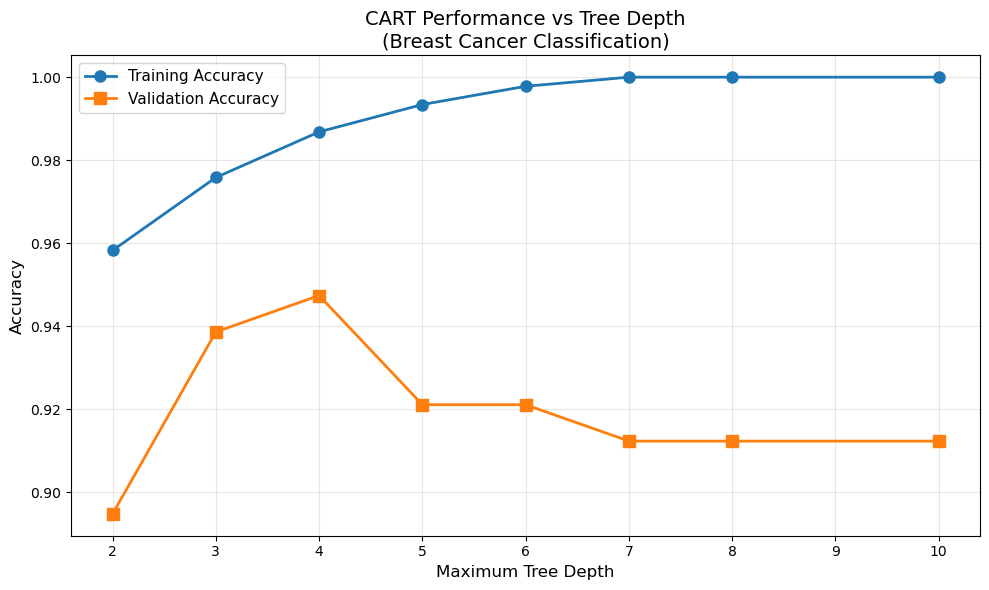


Best max_depth: 4 (Validation Accuracy: 0.9474)


In [6]:
# Main - Run CART on Breast Cancer Dataset

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def load_breast_cancer_data():
    """
    Load and prepare the Breast Cancer Wisconsin dataset.
    This assumes you have the data in the same format as HW04.
    
    If you don't have the exact files, you can use sklearn's built-in dataset:
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X, y = data.data, data.target
    """
    try:
        # Try loading from data directory (HW04 format)
        X_train = pd.read_csv('data/X_train.csv', header=None)
        Y_train = pd.read_csv('data/y_train.csv', header=None)
        X_val = pd.read_csv('data/X_val.csv', header=None)
        Y_val = pd.read_csv('data/y_val.csv', header=None)
        
        Y_train = np.array([i[0] for i in Y_train.values])
        Y_val = np.array([i[0] for i in Y_val.values])
        
        X_train = np.array(X_train)
        X_val = np.array(X_val)
        
        print("Loaded data from data/ directory")
        return X_train, X_val, Y_train, Y_val
        
    except FileNotFoundError:
        # Fall back to sklearn's built-in dataset
        print("data/ directory not found, using sklearn's built-in breast cancer dataset")
        from sklearn.datasets import load_breast_cancer
        
        data = load_breast_cancer()
        X, y = data.data, data.target
        
        # Split into train and validation sets (80-20 split)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        return X_train, X_val, Y_train, Y_val


def main():
    print("=" * 70)
    print("CART DECISION TREE CLASSIFIER - BREAST CANCER CLASSIFICATION")
    print("=" * 70)
    
    # Load data
    print("\n### Loading Data ###")
    X_train, X_val, Y_train, Y_val = load_breast_cancer_data()
    
    print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set size: {X_val.shape[0]} samples")
    print(f"Class distribution in training: {np.bincount(Y_train)}")
    
    # Train our CART implementation
    print("\n### Training Our CART Implementation ###")
    our_clf = DecisionTreeClassifier(
        max_depth=5, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    our_clf.fit(X_train, Y_train)
    
    # Make predictions
    train_pred = our_clf.predict(X_train)
    val_pred = our_clf.predict(X_val)
    
    # Calculate accuracies
    train_acc = our_clf.score(X_train, Y_train)
    val_acc = our_clf.score(X_val, Y_val)
    
    print(f"\nOur Implementation Results:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Tree Depth: {our_clf.get_depth()}")
    print(f"  Number of Leaves: {our_clf.get_n_leaves()}")
    
    # Train sklearn's implementation for comparison
    print("\n### Training sklearn's Implementation ###")
    sk_clf = SklearnDTC(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    sk_clf.fit(X_train, Y_train)
    
    sk_train_pred = sk_clf.predict(X_train)
    sk_val_pred = sk_clf.predict(X_val)
    
    sk_train_acc = sk_clf.score(X_train, Y_train)
    sk_val_acc = sk_clf.score(X_val, Y_val)
    
    print(f"\nsklearn Implementation Results:")
    print(f"  Training Accuracy: {sk_train_acc:.4f}")
    print(f"  Validation Accuracy: {sk_val_acc:.4f}")
    print(f"  Tree Depth: {sk_clf.get_depth()}")
    print(f"  Number of Leaves: {sk_clf.get_n_leaves()}")
    
    # Comparison
    print("\n### Comparison ###")
    print(f"Training Accuracy Difference: {abs(train_acc - sk_train_acc):.6f}")
    print(f"Validation Accuracy Difference: {abs(val_acc - sk_val_acc):.6f}")
    print(f"Tree Depth Difference: {abs(our_clf.get_depth() - sk_clf.get_depth())}")
    
    # Detailed classification report
    print("\n### Detailed Classification Report (Our Implementation) ###")
    print(classification_report(Y_val, val_pred, target_names=['Malignant', 'Benign']))
    
    # Confusion matrix
    print("\n### Confusion Matrix (Our Implementation) ###")
    cm = confusion_matrix(Y_val, val_pred)
    print(cm)
    print("\nConfusion Matrix Interpretation:")
    print(f"  True Negatives (Malignant correctly classified): {cm[0, 0]}")
    print(f"  False Positives (Malignant misclassified as Benign): {cm[0, 1]}")
    print(f"  False Negatives (Benign misclassified as Malignant): {cm[1, 0]}")
    print(f"  True Positives (Benign correctly classified): {cm[1, 1]}")
    
    # Hyperparameter tuning demonstration
    print("\n### Hyperparameter Tuning ###")
    print("Testing different max_depth values...")
    
    depths = [2, 3, 4, 5, 6, 7, 8, 10]
    train_accs = []
    val_accs = []
    
    for depth in depths:
        clf_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf_temp.fit(X_train, Y_train)
        train_accs.append(clf_temp.score(X_train, Y_train))
        val_accs.append(clf_temp.score(X_val, Y_val))
        print(f"  max_depth={depth:2d}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")
    
    # Plot accuracy vs depth
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accs, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(depths, val_accs, 's-', label='Validation Accuracy', linewidth=2, markersize=8)
    plt.xlabel('Maximum Tree Depth', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('CART Performance vs Tree Depth\n(Breast Cancer Classification)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('cart_depth_analysis.png', dpi=150, bbox_inches='tight')
    print("\nSaved plot as 'cart_depth_analysis.png'")
    plt.show()
    
    # Find best depth
    best_depth_idx = np.argmax(val_accs)
    best_depth = depths[best_depth_idx]
    best_val_acc = val_accs[best_depth_idx]
    print(f"\nBest max_depth: {best_depth} (Validation Accuracy: {best_val_acc:.4f})")
    
    print("=" * 70)

# Set random seed for reproducibility
np.random.seed(42)

# Run main
main()